<a href="https://colab.research.google.com/github/ericburdett/record_detection/blob/master/record_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Record Detection

This notebook contains code to segment records from historical documents. It
uses the Matterport implementation of MaskRCNN and follows the TowardsDataScience blog post as described [here](https://towardsdatascience.com/object-detection-using-mask-r-cnn-on-a-custom-dataset-4f79ab692f6d)

In [4]:
try:
  %tensorflow_version 1.x
except Exception:
  pass

TensorFlow 1.x selected.


In [5]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 116.75 MiB | 13.42 MiB/s, done.
Resolving deltas: 100% (567/567), done.


In [6]:
%cd Mask_RCNN/
!python setup.py install

/content/Mask_RCNN
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/utils.py -> build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/config.py -> build/bdist.li

In [25]:
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize
import mrcnn
from mrcnn.utils import Dataset
from mrcnn.model import MaskRCNN
from mrcnn.model import log

import numpy as np
import colorsys
import argparse
import random
import cv2
import os
import time
import skimage

from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

%matplotlib inline

import time
from os import listdir
import json
from xml.etree import ElementTree

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!cp "/content/drive/My Drive/datasets/french_record_detection_dataset.zip" "/content"
!unzip -q /content/french_record_detection_dataset.zip -d ../

In [0]:
class myMaskRCNNConfig(Config):
  # Give the configuration a recognizable name
  NAME = "MaskRCNN_config"

  # Set the number of GPUs to use along with the number of images per GPU
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1

  # Number of classes (we would normally add +1 for the background)
    # Full + Partial + Background
  NUM_CLASSES = 2 + 1

  # Number of training steps per epoch
  STEPS_PER_EPOCH = 131

  # Learning Rate
  LEARNING_RATE = 0.006

  # Skip detections with < 90% confidence
  DETECTION_MIN_CONFIDENCE = 0.9

  # Setting Max ground truth instances
  MAX_GT_INSTANCES = 10

In [9]:
config = myMaskRCNNConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.006
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [0]:
class RecordDataset(Dataset):
  # Load the dataset definitions
  def load_dataset(self, dataset_dir, is_train=True):
    # Add classes. We have two classes to add.
    self.add_class("dataset", 1, "f") # Full record
    self.add_class("dataset", 2, "p") # Partial record

    # Define data locations for images and annotations
    images_dir = os.path.join(dataset_dir, "images");
    annotations_dir = os.path.join(dataset_dir, "annotations")

    # Iterate through all files in the folder to add class, images, and annotations
    for filename in listdir(images_dir):
      # Extract image id
      image_id = filename.split('.')[0]
      
      # Setting the image file 
      img_path = os.path.join(images_dir, filename)

      # Setting the annotations file
      ann_path = os.path.join(annotations_dir, image_id + '.json')

      if os.path.exists(ann_path):
        json_file = json.load(open(ann_path))
        annotations = json_file['shapes']

        polygons = json_file['shapes']
        height = json_file['imageHeight']
        width = json_file['imageWidth']

        self.add_image('dataset',
                       image_id=image_id,
                       path=img_path,
                       width=width,
                       height=height,
                       polygons=polygons)
      else:
        image = cv2.imread(img_path)
        height = np.size(image, 0)
        width = np.size(image, 1)

        self.add_image('dataset',
                        image_id=image_id,
                        path=img_path,
                        width=width,
                        height=height,
                        polygons=[]) # empty list if there are no annotations
 
  def load_mask(self, image_id):
    # Get details of image
    info = self.image_info[image_id]
    print(info['path'])

    # Convert polygons to a bitmap mask of shape [height, width, instance_count]
    mask = np.zeros([info['height'], info["width"], len(info["polygons"])], dtype=np.uint8)
    classes = []

    for index, polygon in enumerate(info['polygons']):
      label = self.class_names.index(polygon['label'])
      points = polygon['points']

      all_points_x = [pair[0] for pair in points]
      all_points_y = [pair[1] for pair in points]

      # Get indices of pixels inside the polygon and set them to 1
      rr, cc = skimage.draw.polygon(all_points_y, all_points_x)
      mask[rr, cc, index] = 1

      # Append the label to the class list
      classes.append(label)

    # Return mask and array of class IDs of each instance
    return mask, np.asarray(classes, dtype=np.int32)
  
  def image_reference(self, image_id):
    info = self.image_info[image_id]
    print(info)
    return info['path']

In [11]:
train_set_path = '../french_record_detection_dataset'
test_set_path = '../french_record_detection_dataset'

# Prepare Train Set
train_set = RecordDataset()
train_set.load_dataset(train_set_path)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# Prepare Test/Val Set
test_set = RecordDataset()
test_set.load_dataset(test_set_path)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 22
Test: 22


../french_record_detection_dataset/images/frad069_03_4e_000250_16_0002.tif


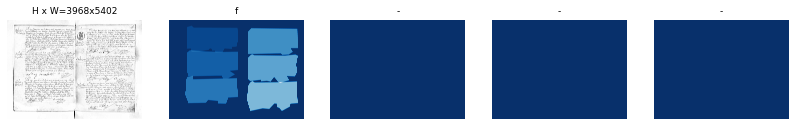

../french_record_detection_dataset/images/frad069_03_4e_000250_16_0008.tif


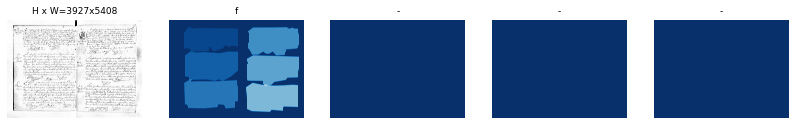

../french_record_detection_dataset/images/frad069_03_4e_000103_15_0011.tif


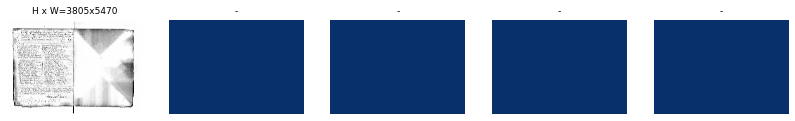

../french_record_detection_dataset/images/frad069_03_4e_000250_16_0019.tif


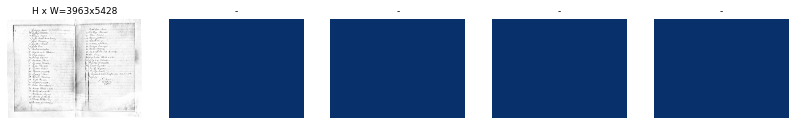

../french_record_detection_dataset/images/frad069_03_4e_000103_15_0001.tif


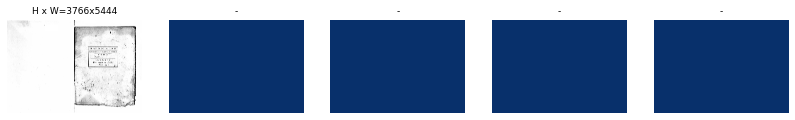

../french_record_detection_dataset/images/frad069_03_4e_000103_15_0008.tif


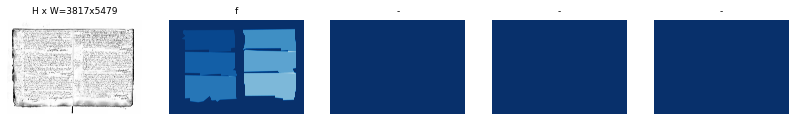

../french_record_detection_dataset/images/frad069_03_4e_000103_15_0006.tif


KeyboardInterrupt: ignored

In [10]:
# image_ids = np.random.choice(train_set.image_ids, 4)
for image_id in train_set.image_ids:
  image = train_set.load_image(image_id)
  mask, class_ids = train_set.load_mask(image_id)
  visualize.display_top_masks(image, mask, class_ids, train_set.class_names)

In [0]:
print("Loading MaskRCNN model...")
model = modellib.MaskRCNN(mode="training", config=config, model_dir='./')

In [0]:
# Load pretrained weights if desired
model.load_weights('./path/to/.h5/file',
                   by_name=True,
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

In [13]:
model.keras_model.metrics_tensors = []
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')
history = model.keras_model.history.history


Starting at epoch 0. LR=0.006

Checkpoint Path: ./maskrcnn_config20200506T2246/mask_rcnn_maskrcnn_config_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4   

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


../french_record_detection_dataset/images/frad069_03_4e_000250_16_0018.tif
../french_record_detection_dataset/images/frad069_03_4e_000250_16_0018.tif
../french_record_detection_dataset/images/frad069_03_4e_000250_16_0018.tif
../french_record_detection_dataset/images/frad069_03_4e_000250_16_0018.tif
../french_record_detection_dataset/images/frad069_03_4e_000103_15_0011.tif
../french_record_detection_dataset/images/frad069_03_4e_000103_15_0011.tif
../french_record_detection_dataset/images/frad069_03_4e_000103_15_0011.tif
../french_record_detection_dataset/images/frad069_03_4e_000103_15_0011.tif
../french_record_detection_dataset/images/frad069_03_4e_000250_16_0008.tif
../french_record_detection_dataset/images/frad069_03_4e_000250_16_0008.tif
../french_record_detection_dataset/images/frad069_03_4e_000250_16_0008.tif
../french_record_detection_dataset/images/frad069_03_4e_000250_16_0008.tif
../french_record_detection_dataset/images/frad069_03_4e_000103_15_0008.tif
../french_record_detectio

In [0]:
model_path = '../maskrcnn.h5'
model.keras_model.save_weights(model_path)
!cp '../maskrcnn.h5' "/content/drive/My Drive/datasets/"

In [0]:
# Loading the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=config, model_dir='../maskrcnn.h5')

# Loading the trained weights to the custom dataset
model.load_weights(model_path, by_name=True)

In [18]:
img = load_img("../french_record_detection_dataset/images/frad069_03_4e_000250_16_0003.tif")
img = img_to_array(img)

result = model.detect([img])
result

[{'class_ids': array([], dtype=int32),
  'masks': array([], shape=(3963, 5398, 0), dtype=float64),
  'rois': array([], shape=(0, 4), dtype=int32),
  'scores': array([], dtype=float32)}]

../french_record_detection_dataset/images/frad069_03_4e_000103_15_0003.tif
original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max: 5477.00000  float64
gt_class_id              shape: (6,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (6, 4)                min:  111.00000  max:  971.00000  int32
gt_mask                  shape: (1024, 1024, 6)       min:    0.00000  max:    1.00000  uint8


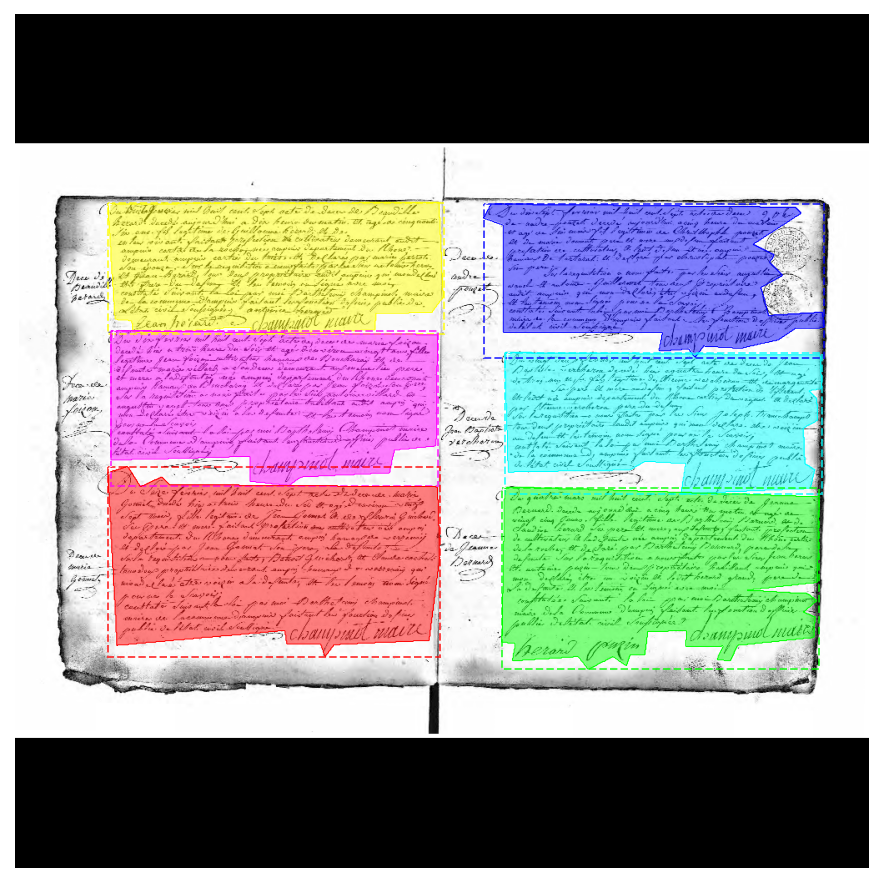

In [30]:
# Test on a random image
image_id = random.choice(test_set.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(test_set, config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            train_set.class_names, figsize=(16, 16))

### Imports and Setup

### Dataset Loading

### Creating TfRecords Dataset

### Model Creation

### Training

### Results